Data generation of a random map with the depot in the middle and 3 random time slots between 8AM and 5PM. Timeslots are 30 minutes

In [340]:
import random
import csv

# Constants
num_nodes = 50
x_depot = 25
y_depot = 25
workday_minutes = 540  # 9 hours * 60 minutes per hour
time_slot_length = 30

# Create a list to store node data
nodes_data = []

# Create the header row
header = "node,x,y,T1_start,T1_end,T2_start,T2_end,T3_start,T3_end"
nodes_data.append(header)

# Create the depot node (Node 0)
nodes_data.append(f"0,{x_depot},{y_depot},0,{workday_minutes},0,{workday_minutes},0,{workday_minutes}")

# Generate random nodes with integer coordinates and unique time slots divisible by 30
used_time_slots = set()
for node_id in range(1, num_nodes):
    x = random.randint(0, 50)
    y = random.randint(0, 50)

    # Generate three unique time slots
    while True:
        t1_start = random.randint(0, (workday_minutes - time_slot_length) // time_slot_length) * time_slot_length
        t1_end = t1_start + time_slot_length

        t2_start = random.randint(0, (workday_minutes - time_slot_length) // time_slot_length) * time_slot_length
        t2_end = t2_start + time_slot_length

        t3_start = random.randint(0, (workday_minutes - time_slot_length) // time_slot_length) * time_slot_length
        t3_end = t3_start + time_slot_length

        time_slots = (t1_start, t1_end, t2_start, t2_end, t3_start, t3_end)
        if time_slots not in used_time_slots and len(set(time_slots)) == len(time_slots):
            used_time_slots.add(time_slots)
            break

    node_data = f"{node_id},{x},{y},{t1_start},{t1_end},{t2_start},{t2_end},{t3_start},{t3_end}"
    nodes_data.append(node_data)

# Save the data to a CSV file
with open('generated_nodes.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    for row in nodes_data:
        writer.writerow(row.split(','))

print("Data saved to 'generated_nodes.csv'.")


Data saved to 'generated_nodes.csv'.


In [341]:
import pandas as pd

df = pd.read_csv('generated_nodes.csv', delimiter=',')

df


,node,x,y,T1_start,T1_end,T2_start,T2_end,T3_start,T3_end
0,0,25,25,0,540,0,540,0,540
1,1,0,36,210,240,480,510,150,180
2,2,12,38,0,30,120,150,60,90
3,3,11,4,120,150,180,210,270,300
4,4,26,2,240,270,0,30,300,330
5,5,0,25,0,30,60,90,390,420
6,6,22,50,240,270,330,360,30,60
7,7,38,1,390,420,180,210,240,270
8,8,33,34,330,360,240,270,390,420
9,9,14,49,120,150,510,540,360,390


### Calculation of the objective functions

In [446]:
import pandas as pd
import itertools
import math
import csv
import random


# Constants
salary = 100
salary_per_minute = 1
diesel_cost_per_km = 10
electric_cost_per_km = 5
end_time = 9 * 60  # 5 PM, is the return time to the depot
start_time = 0  # 8 AM

# Read data from the CSV file
df = pd.read_csv('generated_nodes.csv', delimiter=',')

# Convert the data frame into a list of dictionaries
nodes = []
for index, row in df.iterrows():
    node = {"node": row['node'], "x": row['x'], "y": row['y']}
    if 'T1_start' in df.columns:
        node['timeslots'] = [(row['T1_start'], row['T1_end']), (row['T2_start'], row['T2_end']), (row['T3_start'], row['T3_end'])]
    nodes.append(node)
    
def euclidean_distance(x1, y1, x2, y2):
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def calculate_cost(route, weights=None):
    total_cost = 0
    total_diesel_emission = 0
    total_electric_emission = 0
    customer_dissatisfaction = 0
    time = start_time

    for i in range(1, len(route)):
        x1, y1 = route[i - 1]['x'], route[i - 1]['y']
        x2, y2 = route[i]['x'], route[i]['y']
        distance = euclidean_distance(x1, y1, x2, y2)
        travel_time = distance  # assuming 1 minute per unit distance
        time += travel_time

        # Updating dissatisfaction
        if 'timeslots' in route[i]:
            timeslots = route[i]['timeslots']
            dissatisfaction = 10  # Initialize dissatisfaction to 10 (if no valid time slot is found)
            for j in range(len(timeslots)):
                if timeslots[j][0] <= time <= timeslots[j][1]:
                    dissatisfaction = j
                    break
            customer_dissatisfaction += dissatisfaction
            route[i]['dissatisfaction'] = dissatisfaction

        # Calculate emission based on distance and weight
        if distance > 20:
            total_diesel_emission += distance  # Update diesel emission for this segment
        else:
            total_electric_emission += distance  # Update electric emission for this segment

    # Calculate the total cost based on weights
    if weights:
        if weights['cost']:
            total_cost += salary + (end_time - time) * salary_per_minute
            total_cost += total_diesel_emission * diesel_cost_per_km
            total_cost += total_electric_emission * electric_cost_per_km
        if weights['emission']:
            # Here, we directly add the emission cost if emission weight is non-zero
            total_cost += (total_diesel_emission * diesel_cost_per_km + total_electric_emission * electric_cost_per_km) * weights['emission']
        if weights['dissatisfaction']:
            # Add customer dissatisfaction cost if dissatisfaction weight is non-zero
            total_cost += customer_dissatisfaction * weights['dissatisfaction']

    return total_cost, total_diesel_emission, customer_dissatisfaction





### Greedy algorithm + route

In [343]:
def greedy_algorithm(nodes, weights=None):
    current_node = nodes[0]  # start at the depot
    route = [current_node]  # initiate the route with the depot
    unvisited_nodes = nodes[1:]  # all nodes, except the depot

    while unvisited_nodes:
        next_node = min(unvisited_nodes, key=lambda node: calculate_cost(route + [node], weights)[0])
        unvisited_nodes.remove(next_node)
        route.append(next_node)
    
    route.append(nodes[0])
    
    return route

In [344]:
def print_route(route):
    print([node['node'] for node in route])

In [345]:
weights1 = {'cost': 1, 'emission': 0, 'dissatisfaction': 0}
weights2 = {'cost': 0, 'emission': 1, 'dissatisfaction': 0}
weights3 = {'cost': 0, 'emission': 0, 'dissatisfaction': 1}
weights_combined = {'cost': 1/3, 'emission': 1/3, 'dissatisfaction': 1/3}

# Apply greedy algorithm with different weights
route_greedy1 = greedy_algorithm(nodes, weights1)
route_greedy2 = greedy_algorithm(nodes, weights2)
route_greedy3 = greedy_algorithm(nodes, weights3)
route_greedy_combined = greedy_algorithm(nodes, weights_combined)

# Print nodes visited for each weight set
print("Nodes visited for weight1 (cost): ")
print_route(route_greedy1)
print("Nodes visited for weight2 (emission): ")
print_route(route_greedy2)
print("Nodes visited for weight3 (dissatisfaction): ")
print_route(route_greedy3)
print("Nodes visited for combined weights: ")
print_route(route_greedy_combined)

Nodes visited for weight1 (cost): 
[0, 37, 45, 32, 29, 30, 10, 46, 22, 17, 40, 26, 7, 49, 14, 13, 35, 39, 12, 36, 8, 23, 27, 43, 42, 44, 6, 9, 11, 48, 47, 2, 31, 28, 18, 1, 5, 16, 24, 15, 41, 34, 19, 3, 20, 25, 21, 38, 4, 33, 0]
Nodes visited for weight2 (emission): 
[0, 2, 1, 5, 15, 3, 4, 7, 13, 8, 6, 9, 11, 18, 16, 19, 10, 17, 14, 12, 23, 27, 31, 24, 20, 21, 22, 26, 29, 25, 30, 32, 33, 35, 36, 37, 34, 38, 40, 39, 45, 41, 46, 49, 47, 28, 48, 42, 43, 44, 0]
Nodes visited for weight3 (dissatisfaction): 
[0, 2, 37, 48, 5, 21, 30, 3, 13, 15, 1, 4, 38, 43, 33, 18, 7, 28, 17, 16, 6, 8, 9, 10, 11, 12, 14, 19, 20, 22, 23, 24, 25, 26, 27, 29, 31, 32, 34, 35, 36, 39, 40, 41, 42, 44, 45, 46, 47, 49, 0]
Nodes visited for combined weights: 
[0, 37, 45, 32, 29, 30, 10, 46, 22, 17, 40, 26, 7, 49, 35, 14, 13, 39, 12, 36, 8, 23, 27, 43, 42, 44, 6, 9, 11, 48, 47, 2, 31, 28, 18, 1, 5, 16, 24, 15, 41, 34, 19, 3, 20, 25, 21, 38, 4, 33, 0]


### Two opt algorithm + route

In [350]:
def two_opt_segment(route, weights=None):
    # Ensure that the route starts and ends at node 0
    route = route + [route[0]]
    best = route
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route)):
                if j - i == 1:
                    continue
                new_route = route[:]
                new_route[i:j] = route[j - 1:i - 1:-1]  # Apply 2-opt exchange
                if calculate_cost(new_route, weights)[0] < calculate_cost(best, weights)[0]:
                    best = new_route
                    improved = True
        route = best
    return best

def two_opt(route, weights=None, segment_size=10):
    # Ensure that the route starts and ends at node 0
    route = route + [route[0]]
    best = route
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route)):
                if j - i == 1:
                    continue
                new_route = route[:]
                new_route[i:j] = route[j - 1:i - 1:-1]  # Apply 2-opt exchange
                if calculate_cost(new_route, weights)[0] < calculate_cost(best, weights)[0]:
                    best = new_route
                    improved = True
        route = best
    
    # Divide the best route into segments and apply 2-opt_segment to each segment
    segmented_route = []
    for i in range(0, len(best), segment_size):
        segment = best[i:i + segment_size]
        segmented_route += two_opt_segment(segment, weights)
    
    return segmented_route


In [352]:
weights1 = {'cost': 1, 'emission': 0, 'dissatisfaction': 0}
weights2 = {'cost': 0, 'emission': 1, 'dissatisfaction': 0}
weights3 = {'cost': 0, 'emission': 0, 'dissatisfaction': 1}
weights_combined = {'cost': 1/3, 'emission': 1/3, 'dissatisfaction': 1/3}

# generate a random initial route
initial_route = random.sample(nodes[1:], len(nodes) - 1)  # Exclude node 0

# Apply the 2-opt optimization with different weights
route_2opt1 = two_opt(initial_route, weights1)
route_2opt2 = two_opt(initial_route, weights2)
route_2opt3 = two_opt(initial_route, weights3)
route_2opt_combined = two_opt(initial_route, weights_combined)

route_2opt1 = [nodes[0]] + route_2opt1 + [nodes[0]]
route_2opt2 = [nodes[0]] + route_2opt2 + [nodes[0]]
route_2opt3 = [nodes[0]] + route_2opt3 + [nodes[0]]
route_2opt_combined = [nodes[0]] + route_2opt_combined + [nodes[0]]

print("Nodes visited for weight1 (cost): ")
print_route(route_2opt1)
print("Nodes visited for weight2 (emission): ")
print_route(route_2opt2)
print("Nodes visited for weight3 (dissatisfaction): ")
print_route(route_2opt3)
print("Nodes visited for combined weights: ")
print_route(route_2opt_combined)


Nodes visited for weight1 (cost): 
[0, 44, 6, 9, 11, 48, 47, 37, 32, 33, 45, 44, 29, 22, 46, 30, 10, 34, 41, 24, 2, 15, 29, 31, 28, 18, 1, 16, 25, 3, 19, 20, 5, 31, 21, 38, 4, 26, 7, 49, 14, 13, 40, 17, 21, 35, 39, 8, 27, 43, 44, 42, 23, 36, 12, 35, 0]
Nodes visited for weight2 (emission): 
[0, 44, 6, 27, 43, 31, 28, 20, 29, 47, 9, 44, 34, 5, 16, 24, 18, 1, 11, 42, 48, 45, 34, 12, 14, 4, 41, 19, 22, 7, 38, 49, 40, 12, 46, 26, 32, 23, 33, 36, 35, 39, 8, 13, 46, 10, 15, 2, 44, 37, 17, 21, 25, 3, 30, 10, 0]
Nodes visited for weight3 (dissatisfaction): 
[0, 44, 28, 39, 6, 9, 14, 3, 30, 15, 35, 44, 31, 43, 37, 17, 32, 23, 34, 20, 42, 48, 31, 45, 26, 13, 38, 8, 29, 47, 19, 22, 7, 45, 10, 40, 1, 18, 5, 21, 36, 25, 33, 12, 10, 41, 4, 24, 49, 46, 2, 27, 11, 16, 44, 41, 0]
Nodes visited for combined weights: 
[0, 44, 42, 36, 12, 39, 33, 8, 23, 27, 43, 44, 35, 14, 13, 40, 17, 26, 4, 38, 7, 49, 35, 21, 3, 19, 20, 25, 34, 10, 30, 22, 46, 21, 41, 16, 5, 24, 47, 45, 37, 32, 29, 15, 41, 48, 2, 1, 18, 

### ### Genetic algorithm + route

In [366]:
def genetic_algorithm(nodes, start_node, n_generation, population_size, weights=None):
    def generate_population(nodes, population_size):
        return [random.sample(nodes[1:], len(nodes) - 1) for _ in range(population_size)]

    def breed(parent1, parent2):
        child = []
        child_p1 = []
        child_p2 = []

        gene_a = int(random.random() * len(parent1))
        gene_b = int(random.random() * len(parent1))

        start_gene = min(gene_a, gene_b)
        end_gene = max(gene_a, gene_b)

        for i in range(start_gene, end_gene):
            child_p1.append(parent1[i])

        child_p2 = [item for item in parent2 if item not in child_p1]

        child = child_p1 + child_p2
        return child

    def mutate(individual, mutation_rate):
        for swapped in range(len(individual)):
            if(random.random() < mutation_rate):
                swap_with = int(random.random() * len(individual))

                node1 = individual[swapped]
                node2 = individual[swap_with]

                individual[swapped] = node2
                individual[swap_with] = node1
        return individual

    def evolve_population(pop, elite_size, mutation_rate):
        results = [calculate_cost([start_node] + individual + [start_node], weights) for individual in pop]
        selection_results = sorted(range(len(results)), key=lambda i: results[i])[:elite_size]

        mating_pool = [pop[i] for i in selection_results]

        children = []
        length = len(pop) - elite_size
        pool = random.sample(mating_pool, len(mating_pool))

        for i in range(0, elite_size):
            children.append(mating_pool[i])

        for i in range(0, length):
            child = breed(pool[i % len(pool)], pool[(len(mating_pool) - i - 1) % len(pool)])
            children.append(child)

        next_generation = [mutate(child, mutation_rate) for child in children]

        return next_generation

    pop = generate_population(nodes, population_size)

    for i in range(n_generation):
        pop = evolve_population(pop, 20, 0.01)

    best_route = min(pop, key=lambda route: calculate_cost([start_node] + route + [start_node], weights))

    return [start_node] + best_route + [start_node]


In [398]:
weights1 = {'cost': 1, 'emission': 0, 'dissatisfaction': 0}
weights2 = {'cost': 0, 'emission': 1, 'dissatisfaction': 0}
weights3 = {'cost': 0, 'emission': 0, 'dissatisfaction': 1}
weights_combined = {'cost': 1/3, 'emission': 1/3, 'dissatisfaction': 1/3}

start_node = nodes[0]
n_generation = 250
population_size = 500

route_genetic1 = genetic_algorithm(nodes, start_node, n_generation, population_size, weights1)
route_genetic2 = genetic_algorithm(nodes, start_node, n_generation, population_size, weights2)
route_genetic3 = genetic_algorithm(nodes, start_node, n_generation, population_size, weights3)
route_genetic_combined = genetic_algorithm(nodes, start_node, n_generation, population_size, weights_combined)

print("Nodes visited for weight1 (cost): ")
print_route(route_genetic1)
print("Nodes visited for weight2 (emission): ")
print_route(route_genetic2)
print("Nodes visited for weight3 (dissatisfaction): ")
print_route(route_genetic3)
print("Nodes visited for combined weights: ")
print_route(route_genetic_combined)


Nodes visited for weight1 (cost): 
[0, 32, 15, 24, 1, 16, 25, 20, 34, 19, 3, 21, 38, 46, 4, 7, 49, 26, 17, 40, 14, 13, 33, 8, 36, 12, 39, 35, 22, 29, 30, 10, 41, 5, 18, 28, 31, 2, 9, 11, 47, 48, 27, 43, 44, 6, 42, 23, 45, 37, 0]
Nodes visited for weight2 (emission): 
[0, 17, 39, 8, 14, 36, 35, 7, 26, 49, 13, 45, 30, 15, 29, 47, 41, 19, 46, 22, 32, 4, 38, 34, 24, 2, 18, 11, 23, 6, 9, 43, 42, 12, 33, 27, 44, 37, 40, 21, 10, 3, 20, 16, 25, 5, 28, 1, 31, 48, 0]
Nodes visited for weight3 (dissatisfaction): 
[0, 4, 38, 22, 37, 31, 40, 10, 30, 36, 27, 25, 47, 6, 20, 3, 15, 34, 29, 11, 33, 8, 13, 46, 16, 32, 17, 21, 26, 7, 49, 35, 14, 12, 39, 1, 28, 5, 48, 18, 9, 2, 44, 45, 41, 19, 24, 23, 42, 43, 0]
Nodes visited for combined weights: 
[0, 32, 13, 14, 40, 26, 7, 49, 35, 39, 12, 36, 33, 17, 4, 38, 21, 46, 22, 29, 30, 10, 34, 19, 3, 20, 25, 41, 15, 24, 16, 5, 1, 18, 28, 31, 9, 6, 44, 11, 2, 47, 48, 43, 42, 27, 23, 8, 45, 37, 0]


### Visualisation

In [435]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import itertools
import math


# Determine the color for each customer node based on dissatisfaction
def get_customer_color(dissatisfaction):
    if dissatisfaction == 0:
        return 'green'
    elif dissatisfaction == 1:
        return 'blue'
    elif dissatisfaction == 2:
        return 'orange'
    else:
        return 'red'

# Determine the color for the line between two nodes based on distance
def get_line_color(distance):
    return 'green' if distance < 20 else 'yellow'

# Calculate the dissatisfaction for a specific node
def calculate_dissatisfaction(node, time):
    if 'timeslots' in node:
        timeslots = node['timeslots']
        if timeslots[0][0] <= time <= timeslots[0][1]:
            return 0
        elif timeslots[1][0] <= time <= timeslots[1][1]:
            return 1
        elif timeslots[2][0] <= time <= timeslots[2][1]:
            return 2
        else:
            return 10
    return 0

# Plot the route on a 2D map
def plot_best_route(route, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    # Plot the nodes and the connections between them
    time = start_time
    for i in range(1, len(route)):
        x1, y1 = route[i]['x'], route[i]['y']
        x2, y2 = route[i - 1]['x'], route[i - 1]['y']
        distance = euclidean_distance(x1, y1, x2, y2)
        travel_time = distance  # assuming 1 minute per unit distance for simplicity
        time += travel_time
        dissatisfaction = calculate_dissatisfaction(route[i], time)

        # Plot line
        line_color = get_line_color(distance)
        ax.plot([x1, x2], [y1, y2], color=line_color, linestyle='-', linewidth=2)

        # Plot node
        customer_color = get_customer_color(dissatisfaction)
        ax.plot(x1, y1, marker='o', markersize=8, color=customer_color)

    # Set the color of the first node (depot) to black and add legend entry
    x0, y0 = route[0]['x'], route[0]['y']
    ax.plot(x0, y0, marker='o', markersize=8, color='black', label='Depot')

    # Adding Legend
    legend_elements = [mlines.Line2D([0], [0], color='green', lw=2, label='Electric Distance'),
                       mlines.Line2D([0], [0], color='yellow', lw=2, label='Diesel Distance'),
                       mlines.Line2D([0], [0], marker='o', color='green', markersize=8, lw=0, label='Option 1'),
                       mlines.Line2D([0], [0], marker='o', color='blue', markersize=8, lw=0, label='Option 2'),
                       mlines.Line2D([0], [0], marker='o', color='orange', markersize=8, lw=0, label='Option 3'),
                       mlines.Line2D([0], [0], marker='o', color='red', markersize=8, lw=0, label='No Option'),
                       mlines.Line2D([0], [0], marker='o', color='black', markersize=8, lw=0, label='Depot')]
    ax.legend(handles=legend_elements, loc='upper left')

    # Display plot
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.grid(True)

    if ax is None:
        plt.show()

### Greedy route for each objective function

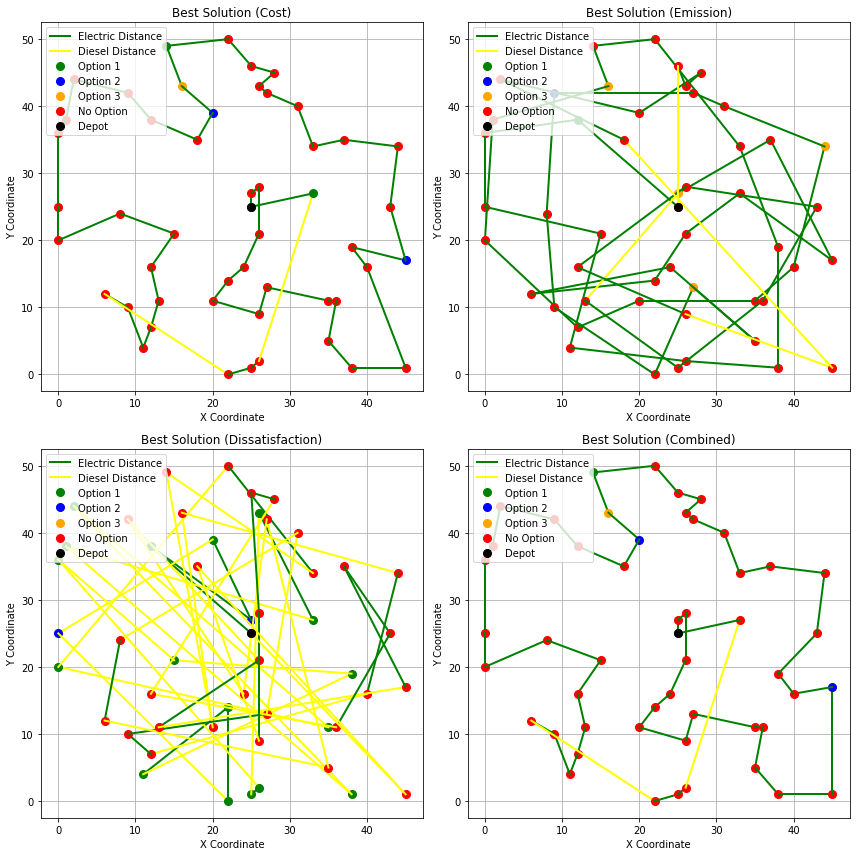

In [436]:
# Define a function to plot the routes in a 2x2 grid
def plot_best_routes_2x2_greedy(route1, route2, route3, route4):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # Plot Route 1 (Cost)
    ax1 = axes[0, 0]
    ax1.set_title("Best Solution (Cost)")
    plot_best_route(route1, ax1)

    # Plot Route 2 (Emission)
    ax2 = axes[0, 1]
    ax2.set_title("Best Solution (Emission)")
    plot_best_route(route2, ax2)

    # Plot Route 3 (Dissatisfaction)
    ax3 = axes[1, 0]
    ax3.set_title("Best Solution (Dissatisfaction)")
    plot_best_route(route3, ax3)

    # Plot Route 4 (Combined)
    ax4 = axes[1, 1]
    ax4.set_title("Best Solution (Combined)")
    plot_best_route(route4, ax4)

    plt.tight_layout()
    plt.show()

# Call the function to plot the routes in a 2x2 grid
plot_best_routes_2x2_greedy(route_greedy1, route_greedy2, route_greedy3, route_greedy_combined)

### Two opt route for each objective function

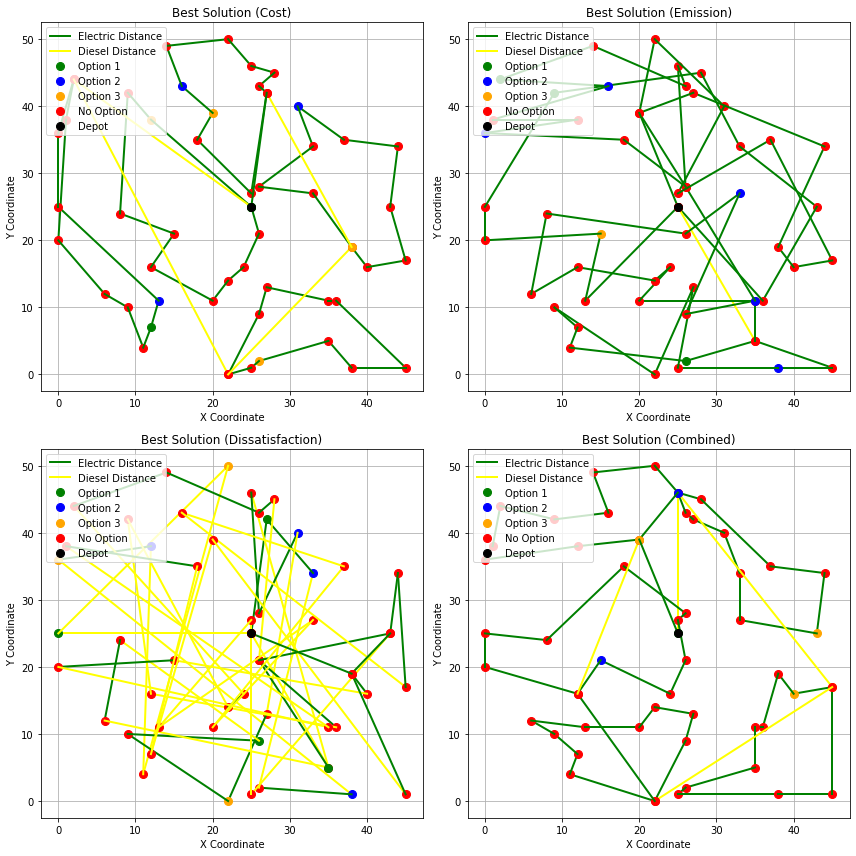

In [453]:
# Define a function to plot the routes in a 2x2 grid
def plot_best_routes_2x2_2opt(route1, route2, route3, route4):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # Plot Route 1 (Cost)
    ax1 = axes[0, 0]
    ax1.set_title("Best Solution (Cost)")
    plot_best_route(route1, ax1)

    # Plot Route 2 (Emission)
    ax2 = axes[0, 1]
    ax2.set_title("Best Solution (Emission)")
    plot_best_route(route2, ax2)

    # Plot Route 3 (Dissatisfaction)
    ax3 = axes[1, 0]
    ax3.set_title("Best Solution (Dissatisfaction)")
    plot_best_route(route3, ax3)

    # Plot Route 4 (Combined)
    ax4 = axes[1, 1]
    ax4.set_title("Best Solution (Combined)")
    plot_best_route(route4, ax4)

    plt.tight_layout()
    plt.show()

# Call the function to plot the routes in a 2x2 grid
plot_best_routes_2x2_2opt(route_2opt1, route_2opt2, route_2opt3, route_2opt_combined)

### Genetic route for each objective function

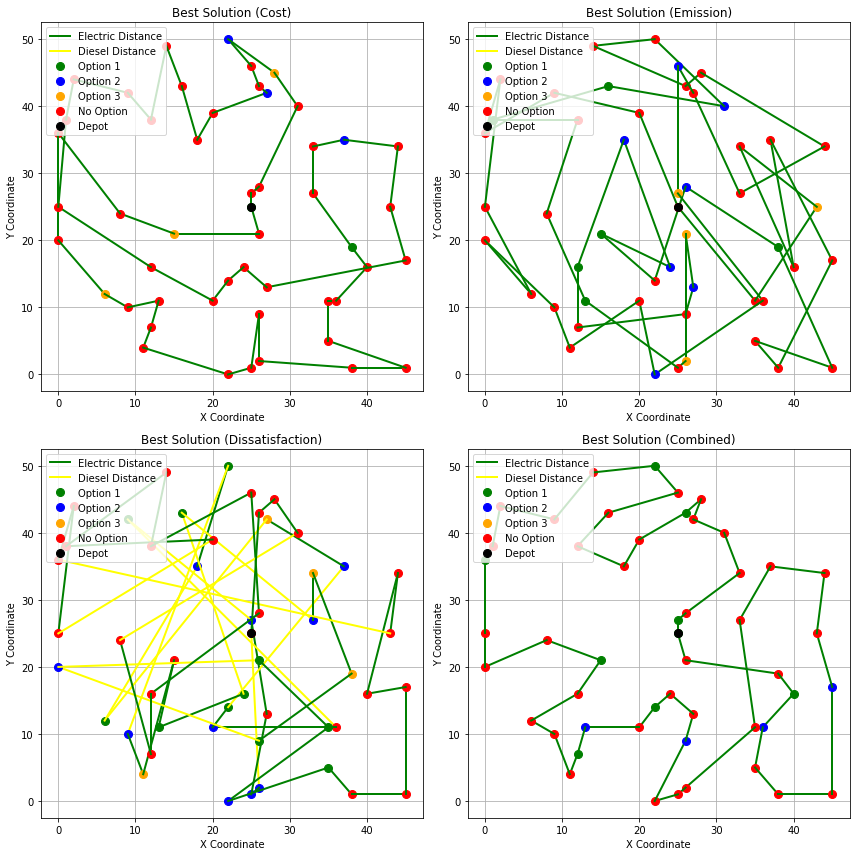

In [432]:
# Define a function to plot the routes in a 2x2 grid
def plot_best_routes_2x2_genetic(route1, route2, route3, route4):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))

    # Plot Route 1 (Cost)
    ax1 = axes[0, 0]
    ax1.set_title("Best Solution (Cost)")
    plot_best_route(route1, ax1)

    # Plot Route 2 (Emission)
    ax2 = axes[0, 1]
    ax2.set_title("Best Solution (Emission)")
    plot_best_route(route2, ax2)

    # Plot Route 3 (Dissatisfaction)
    ax3 = axes[1, 0]
    ax3.set_title("Best Solution (Dissatisfaction)")
    plot_best_route(route3, ax3)

    # Plot Route 4 (Combined)
    ax4 = axes[1, 1]
    ax4.set_title("Best Solution (Combined)")
    plot_best_route(route4, ax4)

    plt.tight_layout()
    plt.show()

# Call the function to plot the routes in a 2x2 grid
plot_best_routes_2x2_genetic(route_genetic1, route_genetic2, route_genetic3, route_genetic_combined)

### Cost Comparison of Greedy, 2-Opt, and Genetic Algorithms

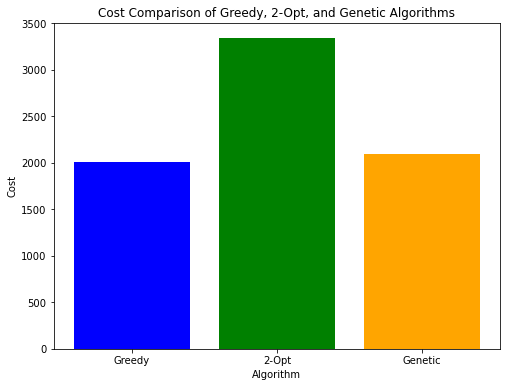

In [451]:
import matplotlib.pyplot as plt

# Calculate the cost of the greedy algorithm (all weight on cost)
greedy_cost = calculate_cost(route_greedy1, weights=weights1)[0]

# Calculate the cost of the 2-opt algorithm (all weight on cost)
two_opt_cost = calculate_cost(route_2opt1, weights=weights1)[0]

# Calculate the cost of the genetic algorithm (all weight on cost)
genetic_cost = calculate_cost(route_genetic1, weights=weights1)[0]

# Create a bar chart
algorithms = ['Greedy', '2-Opt', 'Genetic']
costs = [greedy_cost, two_opt_cost, genetic_cost]

plt.figure(figsize=(8, 6))
plt.bar(algorithms, costs, color=['blue', 'green', 'orange'])
plt.xlabel('Algorithm')
plt.ylabel('Cost')
plt.title('Cost Comparison of Greedy, 2-Opt, and Genetic Algorithms')
plt.show()

### Emission Comparison of Greedy, 2-Opt, and Genetic Algorithms

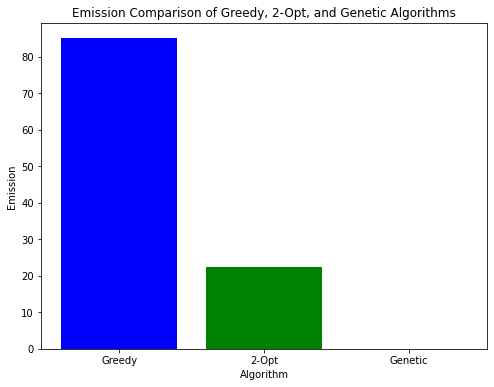

In [449]:
# Calculate the emission of the greedy algorithm (all weight on emission)
greedy_emission = calculate_cost(route_greedy2, weights=weights2)[1]

# Calculate the emission of the 2-opt algorithm (all weight on emission)
two_opt_emission = calculate_cost(route_2opt2, weights=weights2)[1]

# Calculate the emission of the genetic algorithm (all weight on emission)
genetic_emission = calculate_cost(route_genetic2, weights=weights2)[1]

# Create a bar chart for emission comparison
emission_values = [greedy_emission, two_opt_emission, genetic_emission]

plt.figure(figsize=(8, 6))
plt.bar(algorithms, emission_values, color=['blue', 'green', 'orange'])
plt.xlabel('Algorithm')
plt.ylabel('Emission')
plt.title('Emission Comparison of Greedy, 2-Opt, and Genetic Algorithms')
plt.show()


### Customer Dissatisfaction Comparison of Greedy, 2-Opt, and Genetic Algorithms

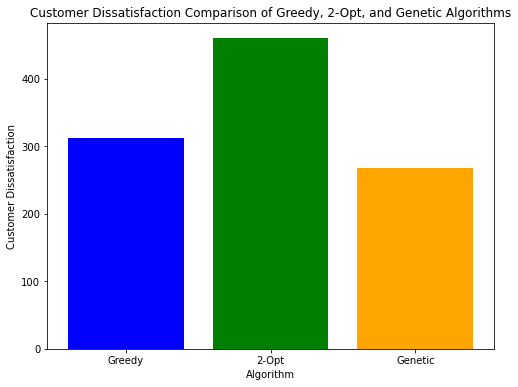

In [452]:
# Calculate the customer dissatisfaction of the greedy algorithm (all weight on dissatisfaction)
greedy_dissatisfaction = calculate_cost(route_greedy3, weights=weights3)[2]

# Calculate the customer dissatisfaction of the 2-opt algorithm (all weight on dissatisfaction)
two_opt_dissatisfaction = calculate_cost(route_2opt3, weights=weights3)[2]

# Calculate the customer dissatisfaction of the genetic algorithm (all weight on dissatisfaction)
genetic_dissatisfaction = calculate_cost(route_genetic3, weights=weights3)[2]

# Create a bar chart for customer dissatisfaction comparison
dissatisfaction_values = [greedy_dissatisfaction, two_opt_dissatisfaction, genetic_dissatisfaction]

plt.figure(figsize=(8, 6))
plt.bar(algorithms, dissatisfaction_values, color=['blue', 'green', 'orange'])
plt.xlabel('Algorithm')
plt.ylabel('Customer Dissatisfaction')
plt.title('Customer Dissatisfaction Comparison of Greedy, 2-Opt, and Genetic Algorithms')
plt.show()


### Combined Score Comparison of Greedy, 2-Opt, and Genetic Algorithms (Combined Weights)

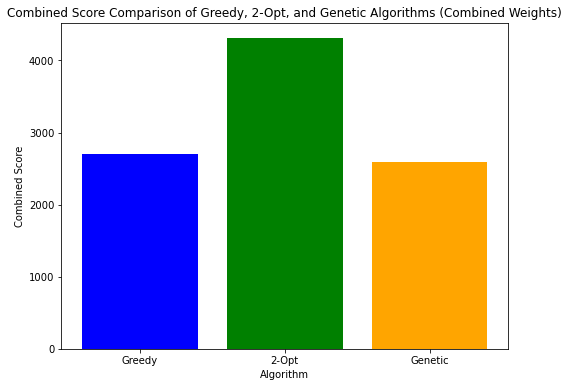

In [454]:
# Calculate the combined score for the combined weight configuration for each algorithm
greedy_combined_score = calculate_cost(route_greedy_combined, weights=weights_combined)[0]
two_opt_combined_score = calculate_cost(route_2opt_combined, weights=weights_combined)[0]
genetic_combined_score = calculate_cost(route_genetic_combined, weights=weights_combined)[0]

# Create a bar chart for combined score comparison with combined weights
combined_score_values = [greedy_combined_score, two_opt_combined_score, genetic_combined_score]

plt.figure(figsize=(8, 6))
plt.bar(algorithms, combined_score_values, color=['blue', 'green', 'orange'])
plt.xlabel('Algorithm')
plt.ylabel('Combined Score')
plt.title('Combined Score Comparison of Greedy, 2-Opt, and Genetic Algorithms (Combined Weights)')
plt.show()


### Combined Scores Along the Routes (Combined Weights)

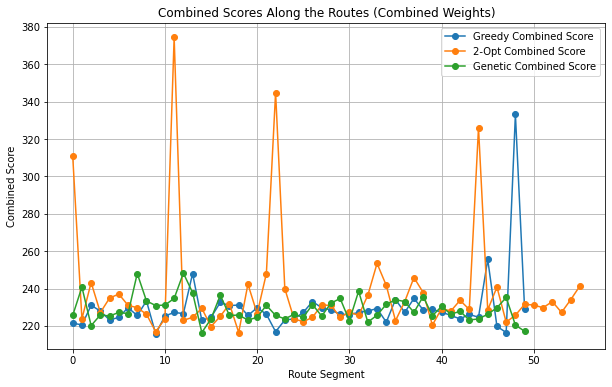

In [460]:
import matplotlib.pyplot as plt

# Calculate the combined score for each route
def calculate_combined_score(route, weights):
    combined_scores = []
    for i in range(len(route) - 1):
        cost = calculate_cost([route[i], route[i + 1]], weights=weights)[0]
        diesel_emission = calculate_cost([route[i], route[i + 1]], weights=weights)[1]
        dissatisfaction = calculate_cost([route[i], route[i + 1]], weights=weights)[2]
        
        # Combine the individual scores based on weights
        combined_score = weights['cost'] * cost + weights['emission'] * diesel_emission + weights['dissatisfaction'] * dissatisfaction
        combined_scores.append(combined_score)
    return combined_scores

# Define the combined weights
combined_weights = {'cost': 1/3, 'emission': 1/3, 'dissatisfaction': 1/3}

# Calculate the combined scores for the routes
greedy_combined_scores = calculate_combined_score(route_greedy_combined, combined_weights)
two_opt_combined_scores = calculate_combined_score(route_2opt_combined, combined_weights)
genetic_combined_scores = calculate_combined_score(route_genetic_combined, combined_weights)

# Create a line chart to visualize the combined scores
plt.figure(figsize=(10, 6))
plt.plot(range(len(route_greedy_combined) - 1), greedy_combined_scores, label='Greedy Combined Score', marker='o', linestyle='-')
plt.plot(range(len(route_2opt_combined) - 1), two_opt_combined_scores, label='2-Opt Combined Score', marker='o', linestyle='-')
plt.plot(range(len(route_genetic_combined) - 1), genetic_combined_scores, label='Genetic Combined Score', marker='o', linestyle='-')

plt.xlabel('Route Segment')
plt.ylabel('Combined Score')
plt.title('Combined Scores Along the Routes (Combined Weights)')
plt.grid(True)
plt.legend()
plt.show()



### Total combined scores of combined weights route

In [464]:
# Create a list of tuples containing algorithm names and total combined scores
algorithm_scores = [
    ("Greedy", total_score_greedy),
    ("2-Opt", total_score_2opt),
    ("Genetic", total_score_genetic)
]

# Sort the list in ascending order based on scores
sorted_scores = sorted(algorithm_scores, key=lambda x: x[1])

# Print the sorted scores
print("Sorted Total Combined Scores (Ascending Order):")
for algorithm, score in sorted_scores:
    print(f"{algorithm}: {score}")


Sorted Total Combined Scores (Ascending Order):
Genetic: 11441.72101163031
Greedy: 11479.224635565235
2-Opt: 13343.013038305422


The presence of outliers in the total combined scores for the 2-Opt and Greedy algorithms while the Genetic algorithm doesn't can be attributed to the different optimization strategies and search spaces explored by these algorithms:

1. **Genetic Algorithm's Population-Based Approach**: Genetic algorithms maintain a population of solutions and evolve them over generations. This population-based approach often helps in exploring a broader search space and avoids getting stuck in local optima. It can also provide more robustness against outliers as extreme scores in one individual may not heavily impact the overall population.

2. **Greedy Algorithm's Local Search**: The Greedy algorithm is a local search heuristic that iteratively selects the best available option at each step. It tends to be more myopic and might get stuck in local optima if it makes a suboptimal choice early on. This can lead to extreme scores, especially if there are segments of the route with particularly high dissatisfaction or emission.

3. **2-Opt Algorithm's Local Search**: Similarly, the 2-Opt algorithm is a local search optimization that swaps segments of the route to improve it. While it can be effective in refining an initial solution, it's not guaranteed to escape local optima either. If the initial solution is suboptimal or if it gets stuck in a suboptimal configuration, it can produce extreme scores.

4. **Population Diversity in Genetic Algorithm**: Genetic algorithms maintain diversity in their population, which means that different individuals explore different parts of the solution space. This diversity can help in avoiding extreme scores because even if some individuals perform poorly on a specific segment, others might perform better.